In [45]:
import numpy as np
import time
from typing import List
import pandas as pd


In [ ]:
def generate_random_configs(num_samples, L, spin_values=(-1, 1)):
    """
    Generate random Ising-like configurations.

    Args:
        num_samples: number of configurations
        L: lattice size (L x L)
        spin_values: possible spin values (default {-1, +1})
    
    Returns:
        X_in: np.ndarray of shape (num_samples, L, L)
    """
    spins = np.random.choice(spin_values, size=(num_samples, L, L))
    return spins

def generate_black_plaquettes(L, return_coords=False, periodic=True):
    """
    Generate black plaquette indices for an L x L checkerboard lattice.

    A plaquette is defined by 4 sites:
      top-left  : (i, j)
      top-right : (i, j+1)
      bot-right : (i+1, j+1)
      bot-left  : (i+1, j)

    A plaquette is considered 'black' if (i + j) % 2 == 0 for the top-left corner.

    Args:
        L (int): lattice linear size (L x L).
        return_coords (bool): if True, return list of plaquettes as lists of (i,j) coords.
                              if False (default), return list of plaquettes as lists of flattened indices.
        periodic (bool): whether to use periodic boundary conditions (wrap edges). Default True.

    Returns:
        plaquettes (list): list of plaquettes. Each plaquette is length-4 list.
                           - If return_coords=True: elements are (i,j) tuples.
                           - If return_coords=False: elements are linear indices idx = i*L + j.
    """
    plaquettes = []
    for i in range(L):
        for j in range(L):
            if (i + j) % 2 != 0:
                continue
            i0, j0 = i, j
            i1, j1 = i, (j + 1) % L if periodic else j + 1
            i2, j2 = (i + 1) % L if periodic else i + 1, (j + 1) % L if periodic else j + 1
            i3, j3 = (i + 1) % L if periodic else i + 1, j

            # if not periodic and index out of bounds, skip
            if not periodic:
                if i1 >= L or j1 >= L or i2 >= L or j2 >= L or i3 >= L or j3 >= L:
                    continue

            if return_coords:
                plaquettes.append([(i0, j0), (i1, j1), (i2, j2), (i3, j3)])
            else:
                idx0 = i0 * L + j0
                idx1 = i1 * L + j1
                idx2 = i2 * L + j2
                idx3 = i3 * L + j3
                plaquettes.append([idx0, idx1, idx2, idx3])
    return plaquettes


def build_site_to_plaquettes(plaquettes: List[List[int]], N: int) -> List[List[int]]:
    """
    Build adjacency: site -> list of plaquette indices that contain the site.
    Use once after generating plaquettes.
    """
    site2pl = [[] for _ in range(N)]
    for p_idx, plaq in enumerate(plaquettes):
        for site in plaq:
            site2pl[site].append(p_idx)
    return site2pl


def plaquette_energy_with_diagonals(spins, plaquettes, J0=1.0, J1=1.0):
    """
    Compute full energy from plaquettes with couplings J0, J1.
    
    spins      : 1D numpy array (length L*L)
    plaquettes : list of plaquettes (indices)
    """
    E = 0.0
    for plaq in plaquettes:
        tl, tr, br, bl = plaq
        E +=   -J0 * spins[tl]*spins[tr]*spins[br]*spins[bl] + \
                J1 * (spins[tl]*spins[br] + spins[tr]*spins[bl])
    return E




def collect_data(L, T, J0, J1, n_samples=1000):
    """
    Generate random spin configurations and compute their energies and probabilities.
    
    Args:
        L (int): Lattice size (LxL).
        T (float): Temperature.
        n_samples (int): Number of random configs.

    Returns:
        dict: {
            "configs": list of np.ndarray (each config shape = (L*L,)),
            "energies": np.ndarray,
            "probs": np.ndarray,
            "T": float
        }
    """
    # generate plaquettes once
    plaquettes = generate_black_plaquettes(L, return_coords=False)

    configs = []
    energies = np.zeros(n_samples)
    weights = np.zeros(n_samples)
    T_list = np.zeros(n_samples)

    for i in range(n_samples):
        spins = np.random.choice([-1, 1], size=L*L)
        E = plaquette_energy_with_diagonals(spins, plaquettes, J0, J1)
        w = np.exp(-E / T)

        configs.append(spins)
        energies[i] = E
        weights[i] = w
        T_list[i] = T

    # Normalize probabilities
    probs = weights 

    return {
        "configs": configs,
        "energies": energies,
        "probs": probs,
        "T": T_list
    }


In [77]:
L = 4
J0 = 1.0
J1 = 0.5
num_samples = 2

# random configs
configs = generate_random_configs(num_samples, L)

# plaquettes
plaquettes = generate_black_plaquettes(L, return_coords=False, periodic=True)

print("Plaquettes are: ", plaquettes)

# energy of first config
conf = configs[0].flatten()
E = plaquette_energy_with_diagonals(conf, plaquettes, J0, J1)

print("Config:\n", configs[0].flatten())
print("Energy:", E)




Plaquettes are:  [[0, 1, 5, 4], [2, 3, 7, 6], [5, 6, 10, 9], [7, 4, 8, 11], [8, 9, 13, 12], [10, 11, 15, 14], [13, 14, 2, 1], [15, 12, 0, 3]]
Config:
 [-1  1  1 -1 -1  1  1  1  1  1  1 -1 -1 -1 -1 -1]
Energy: -4.0


In [78]:
if __name__ == "__main__":
    L = 4
    T = 0.1
    data = collect_data(L, T, J0, J1, n_samples=1000)

    print("Collected data keys:", data.keys())
    df = pd.DataFrame(data)
    df = df.sort_values(by="probs", ascending=False).reset_index(drop=True)

Collected data keys: dict_keys(['configs', 'energies', 'probs', 'T'])


In [79]:
df[0:20]

,configs,energies,probs,T
0,"[-1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, 1, -1, ...",-10.0,2.688117e+43,0.1
1,"[-1, 1, 1, 1, -1, 1, -1, -1, -1, 1, -1, 1, -1,...",-10.0,2.688117e+43,0.1
2,"[-1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, -1,...",-10.0,2.688117e+43,0.1
3,"[-1, 1, 1, 1, 1, 1, -1, -1, 1, 1, -1, -1, -1, ...",-10.0,2.688117e+43,0.1
4,"[1, 1, -1, 1, -1, -1, -1, 1, -1, 1, 1, 1, -1, ...",-10.0,2.688117e+43,0.1
5,"[-1, -1, -1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1...",-10.0,2.688117e+43,0.1
6,"[1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, -1, -1...",-8.0,5.540622e+34,0.1
7,"[-1, -1, -1, 1, 1, 1, 1, -1, -1, -1, -1, 1, 1,...",-8.0,5.540622e+34,0.1
8,"[-1, -1, 1, -1, 1, 1, 1, -1, 1, -1, -1, -1, -1...",-8.0,5.540622e+34,0.1
9,"[1, 1, -1, 1, 1, 1, 1, -1, -1, 1, 1, 1, -1, 1,...",-8.0,5.540622e+34,0.1


In [80]:
df['configs'][0]

array([-1,  1, -1,  1, -1,  1, -1,  1, -1,  1,  1,  1, -1,  1, -1, -1])

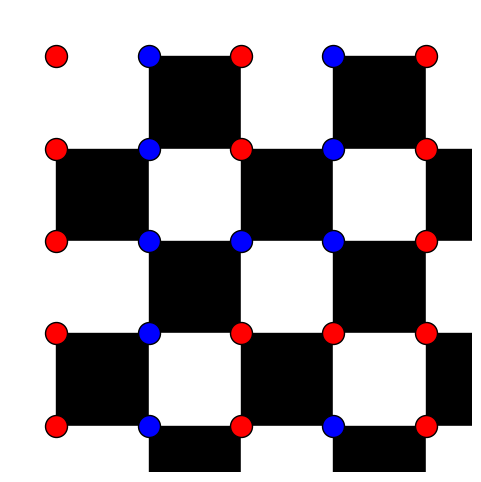

In [125]:
import numpy as np
import matplotlib.pyplot as plt

def plot_spin_config_checkerboard_pbc(spins, L):
    spins = np.array(spins).reshape(L, L)

    fig, ax = plt.subplots(figsize=(6,6))

    # draw checkerboard with PBC (extra row + column)
    for i in range(L):
        for j in range(L):
            if (i + j) % 2 == 0:
                ax.add_patch(plt.Rectangle((j, L-1-i), 1, 1, color="white"))
            else:
                ax.add_patch(plt.Rectangle((j, L-1-i), 1, 1, color="black"))

    # add extra row and column of plaquettes
    for j in range(L):
        if (L + j) % 2 == 0:
            ax.add_patch(plt.Rectangle((j, -1), 1, 1, color="white"))
        else:
            ax.add_patch(plt.Rectangle((j, -1), 1, 1, color="black"))

    for i in range(L):
        if (i + L) % 2 == 0:
            ax.add_patch(plt.Rectangle((L, L-1-i), 1, 1, color="white"))
        else:
            ax.add_patch(plt.Rectangle((L, L-1-i), 1, 1, color="black"))

    # corner plaquette
    ax.add_patch(plt.Rectangle((L, -1), 1, 1, 
                               color="black" if (2*L) % 2 else "white"))

    # plot spins at corners including PBC copies
    for i in range(L+1):
        for j in range(L+1):
            si = spins[i % L, j % L]  # wrap around
            color = "red" if si == -1 else "blue"
            ax.scatter(j, L-i, c=color, s=250, edgecolors="k", zorder=3)

    ax.set_aspect("equal")
    ax.set_xlim(-0.5, L+0.5)
    ax.set_ylim(-0.5, L+0.5)
    ax.axis("off")
    plt.show()


# Example
L = 4
spins = [1, -1, -1, -1,
         1, -1, 1, 1,
         -1, -1, 1, -1,
         1, 1, -1, 1]  # length L*L = 16

plot_spin_config_checkerboard_pbc(df['configs'][0], L)


In [161]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# ---------------------------
# 1. Ising Model Energy
# ---------------------------
def energy(config, L, plaquettes, J0=1.0, J1=0.5):
    """
    Compute energy with 4-spin plaquette interaction and diagonal interactions.
    Uses PBC and a given list of plaquettes.
    
    config : 1D spin array of length L*L (values ±1)
    L      : lattice size
    plaquettes : list of plaquettes, each = (tl, tr, br, bl) indices
    """
    spins = np.array(config).flatten()
    E = 0.0
    for tl, tr, br, bl in plaquettes:
        # 4-spin plaquette term
        E += -J0 * spins[tl] * spins[tr] * spins[br] * spins[bl]
        # diagonal Ising-like terms
        E += J1 * (spins[tl] * spins[br] + spins[tr] * spins[bl])
    return E


def delta_energy(spins, flip_site, plaquettes, J0, J1):
    """
    Compute ΔE for flipping one spin.
    
    spins      : 1D array of length L*L
    flip_site  : index of spin to flip
    plaquettes : list of plaquettes (indices)
    """
    oldE, newE = 0.0, 0.0
    for plaq in plaquettes:
        if flip_site in plaq:   # only plaquettes involving this spin matter
            tl, tr, br, bl = plaq
            # old contribution
            oldE += - J0 * spins[tl]*spins[tr]*spins[br]*spins[bl] + \
                    J1 * (spins[tl]*spins[br] +
                          spins[tr]*spins[bl])
            # new contribution (flip spin at flip_site)
            flipped = spins.copy()
            flipped[flip_site] *= -1
            newE += - J0 * flipped[tl]*flipped[tr]*flipped[br]*flipped[bl] + \
                    J1 * (flipped[tl]*flipped[br] +
                          flipped[tr]*flipped[bl])
    return newE - oldE

def generate_black_plaquettes(L, return_coords=False, periodic=True):
    """
    Generate black plaquette indices for an L x L checkerboard lattice.

    A plaquette is defined by 4 sites:
      top-left  : (i, j)
      top-right : (i, j+1)
      bot-right : (i+1, j+1)
      bot-left  : (i+1, j)

    A plaquette is considered 'black' if (i + j) % 2 == 0 for the top-left corner.

    Args:
        L (int): lattice linear size (L x L).
        return_coords (bool): if True, return list of plaquettes as lists of (i,j) coords.
                              if False (default), return list of plaquettes as lists of flattened indices.
        periodic (bool): whether to use periodic boundary conditions (wrap edges). Default True.

    Returns:
        plaquettes (list): list of plaquettes. Each plaquette is length-4 list.
                           - If return_coords=True: elements are (i,j) tuples.
                           - If return_coords=False: elements are linear indices idx = i*L + j.
    """
    plaquettes = []
    for i in range(L):
        for j in range(L):
            if (i + j) % 2 != 0:
                continue
            i0, j0 = i, j
            i1, j1 = i, (j + 1) % L if periodic else j + 1
            i2, j2 = (i + 1) % L if periodic else i + 1, (j + 1) % L if periodic else j + 1
            i3, j3 = (i + 1) % L if periodic else i + 1, j

            # if not periodic and index out of bounds, skip
            if not periodic:
                if i1 >= L or j1 >= L or i2 >= L or j2 >= L or i3 >= L or j3 >= L:
                    continue

            if return_coords:
                plaquettes.append([(i0, j0), (i1, j1), (i2, j2), (i3, j3)])
            else:
                idx0 = i0 * L + j0
                idx1 = i1 * L + j1
                idx2 = i2 * L + j2
                idx3 = i3 * L + j3
                plaquettes.append([idx0, idx1, idx2, idx3])
    return plaquettes

# ---------------------------
# 2. Dataset
# ---------------------------
class IsingDataset(torch.utils.data.Dataset):
    def __init__(self, L=4, J0=1.0, J1=0.5, n_samples=5000, T=2.0):
        self.L = L
        self.N = L*L
        self.data = []
        plaquettes = generate_black_plaquettes(L, return_coords=False, periodic=True)
        for _ in range(n_samples):
            config = np.random.choice([-1, 1], size=(self.N,))
            dEs = np.array([delta_energy(config, i, plaquettes, J0, J1) for i in range(self.N)])
            probs = np.exp(-dEs/T)
            probs /= probs.sum()
            self.data.append((config, probs))
    
    def __len__(self): return len(self.data)
    
    def __getitem__(self, idx):
        config, probs = self.data[idx]
        return torch.tensor(config, dtype=torch.float32), torch.tensor(probs, dtype=torch.float32)

# ---------------------------
# 3. Policy Network
# ---------------------------
class PolicyNet(nn.Module):
    def __init__(self, N, hidden=128):
        super().__init__()
        self.fc1 = nn.Linear(N, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.out = nn.Linear(hidden, N)
    
    def forward(self, x):
        h = torch.tanh(self.fc1(x))
        h = torch.tanh(self.fc2(h))
        return torch.softmax(self.out(h), dim=-1)

# ---------------------------
# 4. Training Loop
# ---------------------------
def train_policy(L=4, T=2.0, epochs=10, batch_size=64, lr=1e-3):
    dataset = IsingDataset(L=L, T=T, n_samples=5000)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    model = PolicyNet(N=L*L)
    opt = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.KLDivLoss(reduction="batchmean")
    
    for epoch in range(epochs):
        total_loss = 0
        for x, target in loader:
            pred = model(x)
            loss = loss_fn(pred.log(), target)   # minimize KL divergence
            opt.zero_grad()
            loss.backward()
            opt.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss/len(loader):.4f}")
    return model

# ---------------------------
# 5. Example Run
# ---------------------------
L = 4
model = train_policy(L=L, T=1.0, epochs=300)




Epoch 1, Loss: 1.5230
Epoch 2, Loss: 1.5127
Epoch 3, Loss: 1.5077
Epoch 4, Loss: 1.5038
Epoch 5, Loss: 1.4977
Epoch 6, Loss: 1.4845
Epoch 7, Loss: 1.4589
Epoch 8, Loss: 1.4187
Epoch 9, Loss: 1.3538
Epoch 10, Loss: 1.2742
Epoch 11, Loss: 1.1868
Epoch 12, Loss: 1.1040
Epoch 13, Loss: 1.0276
Epoch 14, Loss: 0.9691
Epoch 15, Loss: 0.9169
Epoch 16, Loss: 0.8795
Epoch 17, Loss: 0.8491
Epoch 18, Loss: 0.8139
Epoch 19, Loss: 0.7790
Epoch 20, Loss: 0.7339
Epoch 21, Loss: 0.6893
Epoch 22, Loss: 0.6333
Epoch 23, Loss: 0.5844
Epoch 24, Loss: 0.5346
Epoch 25, Loss: 0.4882
Epoch 26, Loss: 0.4409
Epoch 27, Loss: 0.3961
Epoch 28, Loss: 0.3584
Epoch 29, Loss: 0.3193
Epoch 30, Loss: 0.2873
Epoch 31, Loss: 0.2576
Epoch 32, Loss: 0.2302
Epoch 33, Loss: 0.2078
Epoch 34, Loss: 0.1869
Epoch 35, Loss: 0.1687
Epoch 36, Loss: 0.1525
Epoch 37, Loss: 0.1377
Epoch 38, Loss: 0.1236
Epoch 39, Loss: 0.1111
Epoch 40, Loss: 0.1014
Epoch 41, Loss: 0.0906
Epoch 42, Loss: 0.0822
Epoch 43, Loss: 0.0746
Epoch 44, Loss: 0.06

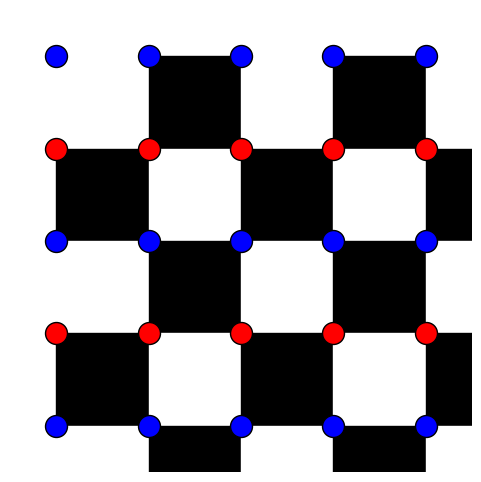

In [165]:

plot_spin_config_checkerboard_pbc(traj[-1].reshape(L, L), L)

In [166]:
energy(traj[-1].reshape(L, L), L, plaquettes, J0=1.0, J1=0.5)

np.float64(-16.0)

In [ ]:
def sample_average_energy(model, L=4, T=1.0, n_steps=5000, burn_in=1000, J0=1.0, J1=0.5):
    """
    Use trained policy network to sample configurations and compute average energy.
    
    model   : trained PolicyNet
    L       : lattice size
    T       : temperature (used only in energy, not directly in model)
    n_steps : total MC steps
    burn_in : number of equilibration steps to discard
    """
    N = L * L
    plaquettes = generate_black_plaquettes(L)
    
    # random initial configuration
    config = np.random.choice([-1, 1], size=(N,))
    
    energies = []
    for step in range(n_steps):
        x = torch.tensor(config, dtype=torch.float32).unsqueeze(0)  # shape (1, N)
        probs = model(x).detach().numpy().flatten()
        
        # propose a spin flip according to ML policy
        flip_site = np.random.choice(N, p=probs)
        
        # compute ΔE
        E_old = energy(config, L, plaquettes, J0, J1)
        config_new = config.copy()
        config_new[flip_site] *= -1
        E_new = energy(config_new, L, plaquettes, J0, J1)
        dE = E_new - E_old
        
        # Metropolis acceptance with Boltzmann weight
        if dE < 0 or np.random.rand() < np.exp(-dE / T):
            config = config_new  # accept move
        
        # measure only after burn-in
        if step >= burn_in:
            E = energy(config, L, plaquettes, J0, J1)
            energies.append(E)

    
    return np.mean(energies), np.std(energies)/np.sqrt(len(energies))  # mean ± error


# ---------------------------
# Example: compute ⟨E⟩ at different T
# ---------------------------
betas = [0.1, 0.5, 1.0, 2.0, 5.0]
energies = []

for T in betas:   # note: here using T = 1/β if you want inverse
    model = train_policy(L=4, T=T, epochs=50)   # retrain at each T
    meanE, errE = sample_average_energy(model, L=4, T=T, n_steps=2000)
    print(f"T={T}, <E> = {meanE:.4f} ± {errE:.4f}")
    energies.append(meanE)

# Plot
import matplotlib.pyplot as plt
plt.plot(betas, energies, "o-")
plt.xlabel("T")
plt.ylabel("<E>")
plt.title("Average Energy vs Temperature (ML policy sampling)")
plt.grid(True)
plt.show()


Epoch 1, Loss: 2.2144
Epoch 2, Loss: 2.2024
Epoch 3, Loss: 2.1961
Epoch 4, Loss: 2.2012
Epoch 5, Loss: 2.1922
Epoch 6, Loss: 2.1766
Epoch 7, Loss: 2.1602
Epoch 8, Loss: 2.1204
Epoch 9, Loss: 2.0659
Epoch 10, Loss: 1.9746
Epoch 11, Loss: 1.8580
Epoch 12, Loss: 1.7249
Epoch 13, Loss: 1.5963
Epoch 14, Loss: 1.4767
Epoch 15, Loss: 1.3774
Epoch 16, Loss: 1.3035
Epoch 17, Loss: 1.2335
Epoch 18, Loss: 1.1889
Epoch 19, Loss: 1.1431
Epoch 20, Loss: 1.1142
Epoch 21, Loss: 1.0966
Epoch 22, Loss: 1.0670
Epoch 23, Loss: 1.0336
Epoch 24, Loss: 1.0038
Epoch 25, Loss: 0.9863
Epoch 26, Loss: 0.9549
Epoch 27, Loss: 0.9187
Epoch 28, Loss: 0.8826
Epoch 29, Loss: 0.8476
Epoch 30, Loss: 0.8079
Epoch 31, Loss: 0.7788
Epoch 32, Loss: 0.7450
Epoch 33, Loss: 0.7106
Epoch 34, Loss: 0.6743
Epoch 35, Loss: 0.6430
Epoch 36, Loss: 0.6129
Epoch 37, Loss: 0.5772
Epoch 38, Loss: 0.5511
Epoch 39, Loss: 0.5204
Epoch 40, Loss: 0.4975
Epoch 41, Loss: 0.4706
Epoch 42, Loss: 0.4456
Epoch 43, Loss: 0.4246
Epoch 44, Loss: 0.40

KeyboardInterrupt: 

In [ ]:
import numpy as np

def ml_mh_sampler(model, L, plaquettes, J0, J1, T,
                  start_config=None, burn_in=2000, n_samples=5000, thinning=1, rng=None):
    """
    model: policy network mapping config -> probs over spin sites
    returns: samples (array n_samples x N), energies list
    """
    if rng is None:
        rng = np.random.default_rng()

    N = L*L
    if start_config is None:
        config = rng.choice([-1,1], size=(N,))
    else:
        config = start_config.copy()

    def energy_fn(cfg): return energy(cfg, L, plaquettes, J0=J0, J1=J1)

    # burn-in
    for _ in range(burn_in):
        x = torch.tensor(config, dtype=torch.float32).unsqueeze(0)
        probs = model(x).detach().cpu().numpy().ravel()
        probs = np.clip(probs, 1e-12, 1-1e-12)
        probs /= probs.sum()
        i = rng.choice(N, p=probs)
        prop = config.copy(); prop[i] *= -1
        dE = delta_energy(config, i, plaquettes, J0, J1)
        if rng.random() < np.exp(-dE / T):
            config = prop

    # sampling
    samples = []
    energies = []
    steps = 0
    while len(samples) < n_samples:
        x = torch.tensor(config, dtype=torch.float32).unsqueeze(0)
        probs = model(x).detach().cpu().numpy().ravel()
        probs = np.clip(probs, 1e-12, 1-1e-12)
        probs /= probs.sum()
        i = rng.choice(N, p=probs)
        prop = config.copy(); prop[i] *= -1
        dE = delta_energy(config, i, plaquettes, J0, J1)
        if rng.random() < np.exp(-dE / T):
            config = prop
        steps += 1
        if steps % thinning == 0:
            samples.append(config.copy())
            energies.append(energy_fn(config))
    return np.array(samples), np.array(energies)


In [189]:
model = train_policy(L=4, T=1.0, epochs=200)   # retrain at each T

Epoch 1, Loss: 1.5105
Epoch 2, Loss: 1.5014
Epoch 3, Loss: 1.4997
Epoch 4, Loss: 1.4937
Epoch 5, Loss: 1.4883
Epoch 6, Loss: 1.4779
Epoch 7, Loss: 1.4620
Epoch 8, Loss: 1.4277
Epoch 9, Loss: 1.3776
Epoch 10, Loss: 1.2982
Epoch 11, Loss: 1.1981
Epoch 12, Loss: 1.1070
Epoch 13, Loss: 1.0237
Epoch 14, Loss: 0.9602
Epoch 15, Loss: 0.9069
Epoch 16, Loss: 0.8666
Epoch 17, Loss: 0.8242
Epoch 18, Loss: 0.7838
Epoch 19, Loss: 0.7431
Epoch 20, Loss: 0.7009
Epoch 21, Loss: 0.6549
Epoch 22, Loss: 0.6041
Epoch 23, Loss: 0.5520
Epoch 24, Loss: 0.4990
Epoch 25, Loss: 0.4506
Epoch 26, Loss: 0.4019
Epoch 27, Loss: 0.3577
Epoch 28, Loss: 0.3163
Epoch 29, Loss: 0.2822
Epoch 30, Loss: 0.2521
Epoch 31, Loss: 0.2229
Epoch 32, Loss: 0.1990
Epoch 33, Loss: 0.1785
Epoch 34, Loss: 0.1599
Epoch 35, Loss: 0.1437
Epoch 36, Loss: 0.1287
Epoch 37, Loss: 0.1166
Epoch 38, Loss: 0.1056
Epoch 39, Loss: 0.0948
Epoch 40, Loss: 0.0854
Epoch 41, Loss: 0.0773
Epoch 42, Loss: 0.0699
Epoch 43, Loss: 0.0637
Epoch 44, Loss: 0.05

In [190]:
samples, energies = ml_mh_sampler(model, L, plaquettes, J0, J1, 1.0,
                                  burn_in=2000, n_samples=20000, thinning=5)
E_mean = energies.mean()/L/L
E_std = energies.std() / np.sqrt(len(energies))
print("⟨E⟩ = {:.6f} ± {:.6f}".format(E_mean, E_std))


⟨E⟩ = -0.999250 ± 0.001895


# Machine learning

In [ ]:
class Plaquette:
    def __init__(self, sites, coord=None):
        self.sites = sites   # list of 4 site indices
        self.coord = coord   # (x, y) coordinate of top-left corner

def generate_black_plaquette_indices(Lx, Ly):
    """
    Generate black plaquette site indices with PBC.
    Each plaquette is tagged by its (x,y) coordinate.
    """
    black_plaquette_indices = []

    def idx(x, y):
        return x * Ly + y

    for x in range(Lx):
        for y in range(Ly):
            if (x + y) % 2 == 0:  # black plaquette condition
                tl = idx(x, y)
                tr = idx(x, (y + 1) % Ly)
                br = idx((x + 1) % Lx, (y + 1) % Ly)
                bl = idx((x + 1) % Lx, y)
                plaquette = Plaquette([tl, tr, br, bl], coord=(x, y))
                black_plaquette_indices.append(plaquette)

    return black_plaquette_indices


def get_black_plaquette_neighbors(plaquette, Lx, Ly):
    """
    Given a black plaquette, return the 4 neighboring plaquettes
    (up, down, left, right) using PBC.
    """
    x, y = plaquette.coord
    neighbors = []

    # Up, Down, Left, Right coordinates
    neighbor_coords = [
        ((x - 2) % Lx, y),       # up (step 2 since checkerboard spacing)
        ((x + 2) % Lx, y),       # down
        (x, (y - 2) % Ly),       # left
        (x, (y + 2) % Ly)        # right
    ]

    # Convert coords back to Plaquette objects
    for nx, ny in neighbor_coords:
        # recompute sites of neighbor
        tl = (nx % Lx) * Ly + (ny % Ly)
        tr = (nx % Lx) * Ly + ((ny + 1) % Ly)
        br = ((nx + 1) % Lx) * Ly + ((ny + 1) % Ly)
        bl = ((nx + 1) % Lx) * Ly + (ny % Ly)
        neighbors.append(Plaquette([tl, tr, br, bl], coord=(nx, ny)))

    return neighbors


In [ ]:
def list_black_plaquettes(Lx, Ly):
    def idx(x, y):
        return x * Ly + y

    black_plaquettes = []

    for x in range(Lx):
        for y in range(Ly):
            if (x + y) % 2 == 0:  # black plaquette condition
                tl = idx(x, y)
                tr = idx(x, (y + 1) % Ly)
                br = idx((x + 1) % Lx, (y + 1) % Ly)
                bl = idx((x + 1) % Lx, y)
                plaquette = [tl, tr, br, bl]
                black_plaquettes.append(plaquette)

    return black_plaquettes


# Example: 4x4 lattice
plaquettes = list_black_plaquettes(4, 4)
for i, p in enumerate(plaquettes):
    print(f"Black plaquette {i}: {p}")


Black plaquette 0: [0, 1, 5, 4]
Black plaquette 1: [2, 3, 7, 6]
Black plaquette 2: [5, 6, 10, 9]
Black plaquette 3: [7, 4, 8, 11]
Black plaquette 4: [8, 9, 13, 12]
Black plaquette 5: [10, 11, 15, 14]
Black plaquette 6: [13, 14, 2, 1]
Black plaquette 7: [15, 12, 0, 3]


# Autoregressive models for QMC 

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [ ]:
import numpy as np
import time

def random_spins(n_samples: int, L: int, seed: int | None = None) -> np.ndarray:
    """
    Generate random spin configurations on an L x L lattice.
    If seed is None, uses current time to generate a different random state each run.
    """
    if seed is None:
        seed = int(time.time() * 1000) % 2**32  # current time in milliseconds
    rng = np.random.default_rng(seed)
    configs = rng.choice([-1, 1], size=(n_samples, L, L))
    return configs

# -- test snippet --
if __name__ == "__main__":
    samples = random_spins(2, 4)  # different each run
    print("samples[0]:\n", samples[0])


samples[0]:
 [[-1 -1 -1 -1]
 [-1 -1 -1  1]
 [-1  1 -1 -1]
 [ 1 -1  1  1]]


In [ ]:
spins = random_spins(1, 4)

In [ ]:
import torch
import numpy as np

def spins_to_tensor(spins: np.ndarray) -> torch.Tensor:
    """
    Convert NumPy spin array {-1, +1} to PyTorch tensor {0,1} for network input.

    Parameters
    ----------
    spins : np.ndarray, shape (batch, L, L)
        Spin configurations with values -1 or +1.

    Returns
    -------
    tensor : torch.Tensor, shape (batch, 1, L, L), dtype=torch.float32
        Spins mapped to {0,1}, ready for neural network.
    """
    tensor = torch.from_numpy((spins + 1) // 2).float()  # -1 ->0, +1->1
    return tensor.unsqueeze(1)  # add channel dimension

def tensor_to_spins(tensor: torch.Tensor) -> np.ndarray:
    """
    Convert PyTorch tensor {0,1} back to spins {-1,+1}.

    Parameters
    ----------
    tensor : torch.Tensor, shape (batch, 1, L, L)
    
    Returns
    -------
    spins : np.ndarray, shape (batch, L, L)
    """
    spins = tensor.squeeze(1).cpu().numpy()
    return 2 * spins - 1  # 0->-1, 1->+1


In [ ]:
spins_to_tensor(spins)

tensor([[[[0., 1., 1., 0.],
          [0., 1., 0., 0.],
          [0., 1., 0., 1.],
          [0., 0., 1., 0.]]]])

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ARWavefunction(nn.Module):
    def __init__(self, L, hidden_dim=128):
        """
        Simple autoregressive network for square lattice spins.

        Parameters
        ----------
        L : int
            Lattice side length.
        hidden_dim : int
            Number of hidden neurons in the fully connected layer.
        """
        super().__init__()
        self.L = L
        self.N = L * L  # total number of spins

        # input: flattened lattice (batch, N)
        self.fc1 = nn.Linear(self.N, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 2)  # output: log-probs for spin ±1

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass: compute log-probabilities for next spin.

        Parameters
        ----------
        x : torch.Tensor, shape (batch, 1, L, L)
            Input spin configuration, {0,1}.

        Returns
        -------
        log_probs : torch.Tensor, shape (batch, 2)
            Log-probabilities for spin -1 or +1 at next site.
        """
        batch_size = x.shape[0]
        x_flat = x.view(batch_size, -1)  # flatten lattice
        h = torch.tanh(self.fc1(x_flat))
        out = self.fc2(h)
        log_probs = F.log_softmax(out, dim=-1)
        return log_probs


In [ ]:
if __name__ == "__main__":
    L = 4
    batch_size = 10

    # generate random spins
    spins = random_spins(batch_size, L)
    tensor = spins_to_tensor(spins)

    # initialize AR network
    ar_net = ARWavefunction(L=L, hidden_dim=64)

    # forward pass
    log_probs = ar_net(tensor)
    print("log_probs shape:", log_probs.shape)  # should be (batch, 2)
    print("log_probs:\n", log_probs)
    probs = torch.exp(log_probs)        # convert log-prob -> probability
    spin_sample = torch.multinomial(probs, 1)  # pick -1 or +1
    print("Sampled spins (0 or 1):\n", spin_sample.squeeze().cpu().numpy())


log_probs shape: torch.Size([10, 2])
log_probs:
 tensor([[-0.6803, -0.7061],
        [-0.6024, -0.7929],
        [-0.9105, -0.5147],
        [-0.5975, -0.7989],
        [-0.7216, -0.6655],
        [-0.7052, -0.6813],
        [-0.5163, -0.9081],
        [-0.6436, -0.7453],
        [-0.6013, -0.7944],
        [-0.4131, -1.0835]], grad_fn=<LogSoftmaxBackward0>)
Sampled spins (0 or 1):
 [1 0 0 0 1 1 0 0 0 0]


In [ ]:
def sample_ar(model: nn.Module, L: int, n_samples: int = 1, device='cpu') -> torch.Tensor:
    """
    Generate lattice configurations autoregressively. Keep graph for backprop.
    """
    N = L * L
    samples = torch.zeros((n_samples, N), device=device)  # start empty lattice

    model.eval()  # you can also keep train mode; up to you
    for i in range(N):
        x_in = samples.clone().view(n_samples, 1, L, L)
        log_probs = model(x_in)  # shape (batch, 2)
        probs = torch.exp(log_probs)

        # Use differentiable sampling: here we use categorical sampling via straight-through trick
        # 1. Sample one-hot
        sampled_onehot = torch.multinomial(probs, num_samples=1)
        # 2. Convert to float and straight-through
        spin_sample = torch.zeros_like(probs)
        spin_sample.scatter_(1, sampled_onehot, 1.0)
        # 3. Take argmax as 0/1 for lattice, but keep gradient
        samples[:, i] = spin_sample[:, 1]  # +1 spin probability
    samples = samples.view(n_samples, 1, L, L)
    return samples


In [ ]:
if __name__ == "__main__":
    L = 4
    ar_net = ARWavefunction(L=L, hidden_dim=64)

    sampled = sample_ar(ar_net, L, n_samples=2)
    print("Sampled tensor shape:", sampled.shape)
    print("Sampled tensor[0,0]:\n", sampled[0,0])

    # Convert back to spins {-1,+1} for energy computation
    spins = tensor_to_spins(sampled)
    print("Sampled spins[0]:\n", spins[0])


Sampled tensor shape: torch.Size([2, 1, 4, 4])
Sampled tensor[0,0]:
 tensor([[1., 0., 0., 0.],
        [0., 1., 1., 1.],
        [0., 0., 1., 1.],
        [0., 1., 1., 1.]])
Sampled spins[0]:
 [[ 1. -1. -1. -1.]
 [-1.  1.  1.  1.]
 [-1. -1.  1.  1.]
 [-1.  1.  1.  1.]]


In [ ]:
def compute_energy(spins: torch.Tensor, J: float = 1.0) -> torch.Tensor:
    """
    Compute nearest-neighbor Ising energy for batch of lattices.

    Parameters
    ----------
    spins : torch.Tensor, shape (batch, 1, L, L), values {-1,+1}
    J : float
        Coupling constant.

    Returns
    -------
    energies : torch.Tensor, shape (batch,)
    """
    batch, _, L, _ = spins.shape
    spins = spins.squeeze(1)  # shape (batch, L, L)
    E = torch.zeros(batch, device=spins.device)

    # horizontal neighbors
    E -= J * (spins * torch.roll(spins, shifts=-1, dims=2)).sum(dim=(1,2))
    # vertical neighbors
    E -= J * (spins * torch.roll(spins, shifts=-1, dims=1)).sum(dim=(1,2))
    return E


In [ ]:
def compute_log_prob(model: nn.Module, samples: torch.Tensor, L: int) -> torch.Tensor:
    """
    Compute log-probabilities of full lattice configurations under AR network.

    Parameters
    ----------
    model : nn.Module
        ARWavefunction network
    samples : torch.Tensor, shape (batch, 1, L, L), values {0,1}
    L : int
        Lattice size

    Returns
    -------
    log_probs : torch.Tensor, shape (batch,)
        Sum of log-probabilities for each configuration
    """
    batch_size = samples.shape[0]
    N = L*L
    log_probs = torch.zeros(batch_size, device=samples.device)

    model.eval()
    for i in range(N):
        x_in = samples.clone().view(batch_size, 1, L, L)
        out = model(x_in)                  # log_softmax output, shape (batch,2)
        idx = samples.view(batch_size, N)[:, i].long()  # 0 or 1 for spin
        log_probs += out.gather(1, idx.unsqueeze(1)).squeeze(1)
    return log_probs


In [ ]:
def train_vmc_logprob(model: nn.Module, L: int, n_epochs: int = 50, batch_size: int = 32,
                       lr: float = 1e-3, device='cpu', J: float = 1.0):
    """
    VMC training using log-derivative trick (REINFORCE).
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.to(device)

    for epoch in range(1, n_epochs+1):
        model.train()

        # Step 1: sample lattice configurations (discrete spins 0/1)
        samples = sample_ar(model, L, n_samples=batch_size, device=device)

        # Step 2: convert to spins {-1,+1} for energy computation
        spins = 2*samples - 1
        spins = spins.float()

        # Step 3: compute energies
        E_loc = compute_energy(spins, J=J)  # shape (batch,)

        # Step 4: compute log-probabilities
        logP = compute_log_prob(model, samples, L)  # shape (batch,)

        # Step 5: REINFORCE loss
        E_mean = E_loc.mean()
        loss = ((E_loc - E_mean) * logP ).mean()

        # Step 6: update network
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 5 == 0 or epoch == 1:
            print(f"Epoch {epoch:03d}: mean energy = {E_loc.mean().item():.4f}")


In [ ]:
if __name__ == "__main__":
    L = 4
    ar_net = ARWavefunction(L=L, hidden_dim=128)
    train_vmc_logprob(ar_net, L, n_epochs=2000, batch_size=1024)


Epoch 001: mean energy = -0.7422
Epoch 005: mean energy = -1.2422
Epoch 010: mean energy = -3.3086
Epoch 015: mean energy = -6.1055
Epoch 020: mean energy = -9.0781
Epoch 025: mean energy = -11.8945
Epoch 030: mean energy = -15.2227
Epoch 035: mean energy = -17.4414
Epoch 040: mean energy = -19.9453
Epoch 045: mean energy = -21.9492
Epoch 050: mean energy = -23.8086
Epoch 055: mean energy = -25.1992
Epoch 060: mean energy = -26.5625
Epoch 065: mean energy = -27.4180
Epoch 070: mean energy = -28.4727
Epoch 075: mean energy = -28.6875
Epoch 080: mean energy = -29.3789
Epoch 085: mean energy = -29.8242
Epoch 090: mean energy = -30.1055
Epoch 095: mean energy = -30.4453
Epoch 100: mean energy = -30.4805
Epoch 105: mean energy = -30.6562
Epoch 110: mean energy = -31.0625
Epoch 115: mean energy = -30.8906
Epoch 120: mean energy = -31.1211
Epoch 125: mean energy = -31.1953
Epoch 130: mean energy = -31.2422
Epoch 135: mean energy = -31.3203
Epoch 140: mean energy = -31.4609
Epoch 145: mean ene

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

# Device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# TFIM parameters
L = 6            # Number of spins
T = 1.0          # Temperature
h = 1.0          # Transverse field
J = 1.0          # Ising coupling
n_samples = 1000 # Monte Carlo samples


Using device: cpu


In [ ]:
# -------------------------------
# Main
# -------------------------------

if __name__ == "__main__":
    L = 4
    T = 0.1
    hidden_dim = 128
    model = ARWavefunctionTemp(L=L, hidden_dim=hidden_dim)
    configs = train_vmc_finiteT(model, L, T, n_epochs=2000, batch_size=64, lr=1e-3, device=device)

Epoch 001: mean energy = 0.2500
Epoch 010: mean energy = -0.6250
Epoch 020: mean energy = -1.6250
Epoch 030: mean energy = -1.8750
Epoch 040: mean energy = -1.2500
Epoch 050: mean energy = -0.6250
Epoch 060: mean energy = -0.9375
Epoch 070: mean energy = -2.6875
Epoch 080: mean energy = -4.5000
Epoch 090: mean energy = -6.3750
Epoch 100: mean energy = -12.2500
Epoch 110: mean energy = -14.6875
Epoch 120: mean energy = -17.6250
Epoch 130: mean energy = -20.3125
Epoch 140: mean energy = -22.0000
Epoch 150: mean energy = -23.3125
Epoch 160: mean energy = -23.2500
Epoch 170: mean energy = -24.7500
Epoch 180: mean energy = -25.0000
Epoch 190: mean energy = -26.6250
Epoch 200: mean energy = -28.3750
Epoch 210: mean energy = -28.6250
Epoch 220: mean energy = -28.1250
Epoch 230: mean energy = -27.6250
Epoch 240: mean energy = -27.6250
Epoch 250: mean energy = -27.2500
Epoch 260: mean energy = -26.6250
Epoch 270: mean energy = -26.2500
Epoch 280: mean energy = -25.7500
Epoch 290: mean energy = 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

# Device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# TFIM parameters
L = 6            # Number of spins
T = 1.0          # Temperature
h = 1.0          # Transverse field
J = 1.0          # Ising coupling
n_samples = 1000 # Monte Carlo samples


In [ ]:
class ARWavefunction(nn.Module):
    def __init__(self, L, hidden_dim=64):
        super().__init__()
        self.L = L
        self.hidden_dim = hidden_dim
        
        # Simple autoregressive layers
        self.fc1 = nn.Linear(L, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, L)
        
    def forward(self, x):
        # x: (batch_size, L) with spins {-1, 1}
        x_in = (x + 1) / 2  # Map to {0,1} for network
        h = F.relu(self.fc1(x_in))
        logits = self.fc2(h)
        # Probabilities for spin up
        probs = torch.sigmoid(logits)
        return probs


In [ ]:
def sample_ar(model, L, n_samples):
    samples = torch.zeros((n_samples, L), device=device)
    
    for i in range(L):
        probs = model(samples)[:, i]
        spins = torch.bernoulli(probs) * 2 - 1  # {0,1} -> {-1,1}
        samples[:, i] = spins
    return samples


In [ ]:
def energy_tfim(configs, J, h):
    # configs: (n_samples, L)
    n_samples, L = configs.shape
    E = torch.zeros(n_samples, device=configs.device)
    
    # ZZ interaction (periodic boundary)
    E -= J * torch.sum(configs * torch.roll(configs, shifts=-1, dims=1), dim=1)
    
    # Transverse field <X>
    # <X> ~ sum over spin flips
    for i in range(L):
        flipped = configs.clone()
        flipped[:, i] *= -1
        # Energy contribution from flip
        E -= h * torch.ones(n_samples, device=configs.device)
    
    return E


In [ ]:
model = ARWavefunction(L).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

n_epochs = 200

for epoch in range(n_epochs):
    samples = sample_ar(model, L, n_samples)
    E = energy_tfim(samples, J, h)
    
    # Free energy loss: <E> - T * <log_prob>
    x_in = (samples + 1) / 2
    probs = model(samples)
    log_prob = torch.sum(samples * torch.log(probs + 1e-8) + (1-samples)/2 * torch.log(1-probs + 1e-8), dim=1)
    
    loss = torch.mean(E - T * log_prob)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss = {loss.item():.4f}, Energy = {E.mean().item():.4f}")


Epoch 0, Loss = -3.9393, Energy = -5.9440
Epoch 20, Loss = -25.9357, Energy = -11.2120
Epoch 40, Loss = -69.4114, Energy = -12.0000
Epoch 60, Loss = -122.4473, Energy = -12.0000
Epoch 80, Loss = -122.5236, Energy = -12.0000
Epoch 100, Loss = -122.5239, Energy = -12.0000
Epoch 120, Loss = -122.5239, Energy = -12.0000
Epoch 140, Loss = -122.5239, Energy = -12.0000
Epoch 160, Loss = -122.5239, Energy = -12.0000
Epoch 180, Loss = -122.5239, Energy = -12.0000
